MOVE STUFF HERE FROM skillcornerSmooth.ipynb

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import CubicSpline
from mplsoccer.pitch import Pitch
import json
import pandas as pd
import re
from math import isnan, sqrt
from datetime import datetime, timedelta
from smoothing import performSmoothing, euclidianDistance

/Users/safefleet/Desktop/Bachelor Thesis/.env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
import csv

def read_csv_partially(file_path, start_line, end_line):
    data = []  # List to store extracted CSV rows

    with open(file_path, 'r', newline='') as file:
        reader = csv.reader(file)
        for line_num, row in enumerate(reader):
            if line_num >= start_line and line_num <= end_line:
                # Append the row to data
                data.append(row)
            elif line_num > end_line:
                break  # Stop reading once end_line is reached

    return data

In [3]:
def plotMovement(playerID, df, start_frame=34591, end_frame=34764):

    pitch = Pitch(pitch_type='skillcorner', axis=True, label=True,
                  pitch_length=105, pitch_width=68,
                  pitch_color='white', line_color='black',)

    df = df[df['object_id'] == playerID].copy().reset_index()

    fig, ax = pitch.draw(figsize=(20, 16), constrained_layout=True, tight_layout=False)
    window = [60,-60,60,-60]
    for i, frame in df.iterrows():
        # for i in range(1, len(frame)):
        if frame['frame_id'] >= start_frame and frame['frame_id'] <= end_frame:
            x = float(frame['x'])
            y = float(frame['y'])
            window = [min(x, window[0]), max(x, window[1]), min(y, window[2]), max(y, window[3])]

            if isnan(x) or isnan(y):
                continue
            ax.plot(x, y, 'ro', markersize=5, color='blue')
            if i > 1:
                x_prev = float(df.loc[i-1, 'x'])
                y_prev = float(df.loc[i-1, 'y'])
                if isnan(x_prev) or isnan(y_prev):
                    continue
                ax.plot([x_prev, x], [y_prev, y], 'r-', linewidth=2)
                ax.arrow(x_prev, y_prev, x - x_prev, y - y_prev, color='r', head_width=0.2, head_length=0.4)
    
    ax.set_xlim([window[0]-5, window[1]+5])
    ax.set_ylim([window[2]-5, window[3]+5])
    plt.show()

In [4]:
def plotMovements(playerID, dfs, start_frame, end_frame):
    pitch = Pitch(pitch_type='skillcorner', axis=True, label=True,
                pitch_length=105, pitch_width=68,
                pitch_color='white', line_color='black',)
    
    colors = ['blue', 'green', 'purple', 'orange', 'red', 'yellow', 'black', 'pink', 'brown', 'cyan']

    fig, ax = pitch.draw(figsize=(20, 16), constrained_layout=True, tight_layout=False)
    for index, DF in enumerate(dfs):
        df = DF[DF['object_id'] == playerID].copy().reset_index()
        # add a label for each index in the legend


        window = [60,-60,60,-60]
        for i, frame in df.iterrows():
            # for i in range(1, len(frame)):
            if frame['frame_id'] >= start_frame and frame['frame_id'] <= end_frame:
                x = float(frame['x'])
                y = float(frame['y'])
                window = [min(x, window[0]), max(x, window[1]), min(y, window[2]), max(y, window[3])]

                if isnan(x) or isnan(y):
                    continue
                ax.plot(x, y, 'ro', markersize=5, color=colors[(index*2)%11])
                if i > 1:
                    x_prev = float(df.loc[i-1, 'x'])
                    y_prev = float(df.loc[i-1, 'y'])
                    if isnan(x_prev) or isnan(y_prev):
                        continue
                    if i == 2:
                        ax.plot([x_prev, x], [y_prev, y], colors[(index*3)%11], linewidth=2, label='DF '+str(index+1))
                    else:
                        ax.plot([x_prev, x], [y_prev, y], colors[(index*3)%11], linewidth=2)
                    ax.arrow(x_prev, y_prev, x - x_prev, y - y_prev, color=colors[(index*3)%11], head_width=0.2, head_length=0.4)
    
    ax.set_xlim([window[0]-5, window[1]+5])
    ax.set_ylim([window[2]-5, window[3]+5])
    ax.legend()
    plt.show()

In [5]:
match_id = 1384039

file_path_skillcorner = '../data/matches/Feb/1384039_tracking.csv'
lineup_path = '../data/matches/Feb/1384039_lineup.csv'
partialframes = read_csv_partially(file_path_skillcorner, 0, 1500000)

lineup = read_csv_partially(lineup_path, 0, 33)
# targetIDSkillcorner = 7679
targetIDSkillcorner = 10218
targetPositionsSkillcorner = []

def getTrajectories(teamName, lineup, partialframes):
    playerIDs = set()
    teamName = "FC Basel"

    for player in list(filter(lambda player: player[1] == teamName, lineup[1:])):
        playerIDs.add(str(player[2]))

    targetTrajs = {}
    for ID in playerIDs:
        targetTrajs[ID] = []

    for index, playerFrame in enumerate(partialframes):

        if(playerFrame[4] not in playerIDs or playerFrame[8] == 'True'):
            continue

        # defining datapoints d_i = [x_Coordinate, y_Coordinate, speed, time]
        if targetTrajs[playerFrame[4]] == [] or int(targetTrajs[playerFrame[4]][-1][-1][-1]) != (int(playerFrame[2]) - 1):
            targetTrajs[playerFrame[4]].append([])
            
        targetTrajs[playerFrame[4]][-1].append([float(playerFrame[5]), float(playerFrame[6]), 0, datetime.fromtimestamp(int(playerFrame[3])/1000.0), int(playerFrame[2])])
    return targetTrajs

targetTrajs = getTrajectories("FC Basel", lineup, partialframes)

<h1>Time Series Analysis<h1>

<h3>Speed Smoothing</h3>

In [6]:
isolatedTraj = []
playerID = -1
for player, trajs in targetTrajs.items():
    for traj in trajs:
        if len(traj) >= 318 and len(traj) <= 600:
            print(player)
            playerID = player
            isolatedTraj = traj
            break
    if playerID != -1:
        break

start_frame = isolatedTraj[0][-1]
end_frame = isolatedTraj[-1][-1]
# Leon Avdullahu 659794, starting with frame 38350

# broke = False
# for player, trajs in targetTrajs.items():
#     for(trajectory) in trajs:
#         if trajectory[0][-1] >= 60960 and trajectory[0][-1] <= 60980:
#             isolatedTraj = trajectory
#             broke = True
#             print(trajectory)
#             break
#     if broke:
#         break

# print(isolatedTraj)
smoothIsolatedTrajs = [
    performSmoothing(isolatedTraj, 1),
    performSmoothing(isolatedTraj, 5),
    # performSmoothing(isolatedTraj, 10),
    performSmoothing(isolatedTraj, 50),
    performSmoothing(isolatedTraj, 100),
    # performSmoothing(isolatedTraj, 150),
    # performSmoothing(isolatedTraj, 200),
    # performSmoothing(isolatedTraj, 400),
    performSmoothing(isolatedTraj, 600),
    # performSmoothing(isolatedTraj, 800),
    # performSmoothing(isolatedTraj, 1000),
]

its = [
    1,
    5,
    # 10,
    50,
    100,
    # 150,
    # 200,
    # 400,
    600,
    # 800,
    # 1000,
]
isolatedTraj = pd.DataFrame(isolatedTraj)


59893


**Add Gaussian Filtering on Frecquency Domain of Speed signal**

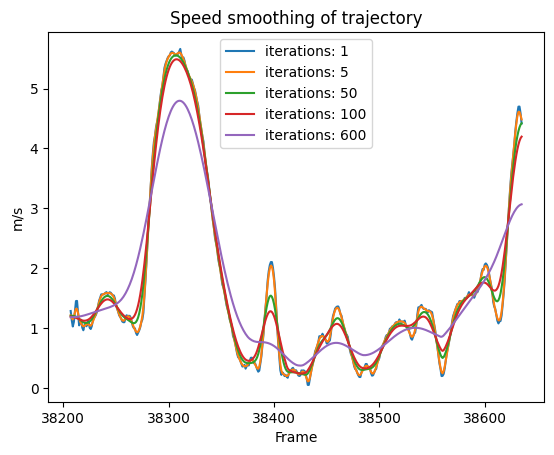

In [7]:
# plot the speed timeseries 
smoothIsolatedTrajsDFs = []
for i, traj in enumerate(smoothIsolatedTrajs):
    # if(i == 2):
    #     continue
    traj = pd.DataFrame(traj)
    
    traj.columns = ['x', 'y', 'speed', 'time', 'frame_id']
    traj['frame_id'] = isolatedTraj[4]
    traj['frame_id'] = traj['frame_id'].astype(int)
    smoothIsolatedTrajsDFs.append(traj)
    plt.plot(traj.loc[:, 'frame_id'][1:-1], (traj.loc[:, 'speed'][1:-1]*10), color='C'+str(i), label='iterations: ' + str(its[i]))

plt.title('Speed smoothing of trajectory')
plt.xlabel('Frame')  # Replace 'Index' with the actual x-axis label
plt.ylabel('m/s')  # Replace 'Value' with the actual y-axis label
plt.legend()
# plt.xlim(38222, 38335)
plt.show()

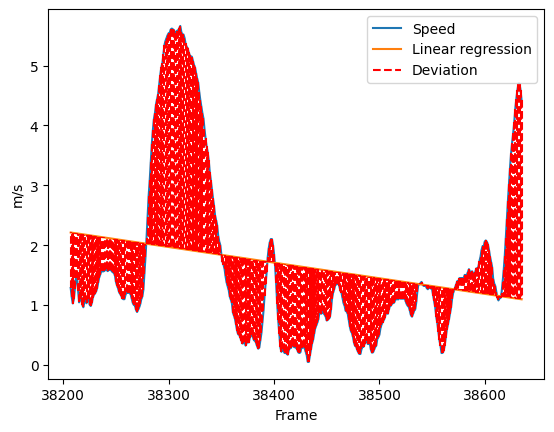

1.4543311722181087


In [9]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

speedTS = pd.DataFrame(smoothIsolatedTrajs[0])
speedTS[2] = speedTS[2]*10
speedTS.columns = ['x', 'y', 'speed', 'time', 'frame_id']
speedTS['frame_id'] = isolatedTraj[4]
speedTS = speedTS[1:-1]
speedTS = speedTS[['speed', 'frame_id']]
smoothDF = speedTS.copy()
# speedTS = speedTS[(speedTS['frame_id'] >= 56050) & (speedTS['frame_id'] < 56060)]

lr.fit(speedTS[['frame_id']], speedTS['speed'])

slope = lr.coef_[0]
intercept = lr.intercept_

speedTS['linear'] = lr.predict(speedTS[['frame_id']])
speedTS['deviation'] = (speedTS['speed'] - speedTS['linear'])**2

plt.plot(speedTS['frame_id'], speedTS['speed'], label='Speed')
plt.plot(speedTS['frame_id'], speedTS['linear'], label='Linear regression')

count = 0
for _, row in speedTS.iterrows():
    if count == 0:
        plt.plot([row['frame_id'], row['frame_id']], [row['speed'], row['linear']], color='r', linestyle='--', label='Deviation')
    else:
        plt.plot([row['frame_id'], row['frame_id']], [row['speed'], row['linear']], color='r', linestyle='--')
    count += 1

plt.xlabel('Frame')  # Replace 'Index' with the actual x-axis label
plt.ylabel('m/s')  # Replace 'Value' with the actual y-axis label
plt.legend()
plt.show()

print(sqrt(speedTS['deviation'].sum()/len(speedTS)))

In [13]:
def getSpeedDeviationHelper(trajectory):
    lr = LinearRegression()

    speedTS = trajectory.copy()
    speedTS = speedTS[['speed', 'frame_id']]

    lr.fit(speedTS[['frame_id']], speedTS['speed'])

    speedTS['linear'] = lr.predict(speedTS[['frame_id']])
    speedTS['deviation'] = (speedTS['speed'] - speedTS['linear'])**2

    return sqrt(speedTS['deviation'].sum()/len(speedTS))

In [14]:
def getSpeedDeviation(trajectory):
    trajectory = pd.DataFrame(trajectory)
    trajectory.columns = ['x', 'y', 'speed', 'time', 'frame_id']
    totalSD = 0
    for i in range(len(trajectory)//10):
        partition = trajectory.iloc[i*10:(i+1)*10, :].copy()
        totalSD += getSpeedDeviationHelper(partition)

    return totalSD/(len(trajectory)//10)

# print(getSpeedDeviation(smoothIsolatedTrajsDFs[6]))

<h1>Trajectory Similarity</h1>

In [15]:
traj1 = list(map(lambda x: [x[0], x[1]], smoothIsolatedTrajs[0]))
traj2 = list(map(lambda x: [x[0], x[1]], smoothIsolatedTrajs[1]))

<h3>Dynamic Time Warping</h3>

Using: https://dtaidistance.readthedocs.io/en/latest/

In [16]:
import dtaidistance
from dtaidistance import dtw_ndim

series1 = np.array(traj1, dtype=np.double)
series2 = np.array(traj2, dtype=np.double)
d = dtw_ndim.distance(series1, series2)

Dmatrix = dtaidistance.dtw_ndim.distance_matrix(series1, series2)
d, paths = dtaidistance.dtw_ndim.warping_paths(series1, series2)
print(d)

def getDTWDistance(DF1, DF2):
    series1 = np.array(DF1[['x', 'y']], dtype=np.double)
    series2 = np.array(DF2[['x', 'y']], dtype=np.double)
    d = dtw_ndim.distance(series1, series2)
    return d

0.19862964746775322


In [17]:
from dtaidistance import dtw_visualisation
dtw_visualisation.plot_warpingpaths(series1, series2, paths, filename="warp.png")

(None, None)

<h3>Lock-Step Distance<h3>

In [18]:
series1 = np.array(traj1, dtype=np.double)
series2 = np.array(traj2, dtype=np.double)

assert(len(series1) == len(series2))
totalDistance = 0
for (x, y) in zip(series1, series2):
    totalDistance += euclidianDistance(x, y)

print(totalDistance)

def getLockStepDistance(DF1, DF2):
    series1 = np.array(DF1[['x', 'y']], dtype=np.double)
    series2 = np.array(DF2[['x', 'y']], dtype=np.double)
    totalDistance = 0
    for (x, y) in zip(series1, series2):
        totalDistance += euclidianDistance(x, y)
    return totalDistance

3.0126736472409683


<h3>Fréchet Distance</h3>

Using: https://pypi.org/project/frechetdist/

In [19]:
import frechetdist

series1 = np.array(traj1, dtype=np.double)
series2 = np.array(traj2, dtype=np.double)

print(frechetdist.frdist(series1, series2))

def getFrechetDistance(DF1, DF2):
    series1 = np.array(DF1[['x', 'y']], dtype=np.double)
    series2 = np.array(DF2[['x', 'y']], dtype=np.double)
    d = frechetdist.frdist(series1, series2)
    return d

0.03345606384136844


- check gps trajectory data to use as "true" reference
- add noise, experiments, longitudinal and lateral noise

In [20]:
SD = []
d = []
for i, traj in enumerate(smoothIsolatedTrajsDFs[1:]):
    SD.append(getSpeedDeviation(traj))

    series1 = np.array(traj[['speed', 'frame_id']], dtype=np.double)
    series2 = np.array(smoothIsolatedTrajsDFs[0][['speed', 'frame_id']], dtype=np.double)
    distance = dtw_ndim.distance(series1, series2)
    d.append(dtw_ndim.distance(series1, series2))
    print(distance)


0.0646391836079461
0.3153751655323751
0.4731456376798272
1.0996528233936513


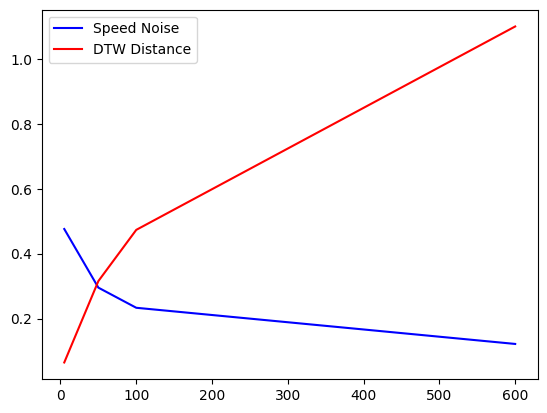

In [21]:
SDcopy = SD.copy()
for idx, S in enumerate(SDcopy):
    SDcopy[idx] *= 100
plt.plot(its[1:], SDcopy, color='blue', label='Speed Noise')
plt.plot(its[1:], d, color='red', label='DTW Distance')
plt.legend()
plt.show()

Conclusion from plots:
- Around 50-100 iterations yields the best smoothing without changing the original trajectory too much

<h3>Acceleration Data from IMU</h3>

In [22]:
file_path_IMU = '../data/matches/Feb/Leon Avdullahu_IMU_1384039.csv'
partialIMU = read_csv_partially(file_path_IMU, 0, 1500000)

In [23]:
def timeStampToFrameID(time_string='01:02:02.960'):
    parts = time_string.split(':')
    hours = int(parts[0])
    minutes = int(parts[1])
    seconds_and_millis = parts[2].split('.')
    seconds = int(seconds_and_millis[0])
    milliseconds = int(seconds_and_millis[1])
    
    # Convert everything to milliseconds
    total_milliseconds = (hours * 3600000) + (minutes * 60000) + (seconds * 1000) + milliseconds
    return total_milliseconds


IMUDF = pd.DataFrame(partialIMU[7:], columns=partialIMU[6])
IMUDF['timestamp'] = IMUDF['Timestamp'].apply(timeStampToFrameID)
IMUDF['object_id'] = playerID
IMUDF['half'] = IMUDF['Period'].apply(lambda x: 1 if x == '1st Half' else 2 if x == '2nd Half' else -1)
firstRow2ndHalf = IMUDF[IMUDF['half'] == 2].iloc[0]
# IMUDF['timestamp'] = IMUDF['timestamp'].apply(lambda x: x - firstRow2ndHalf['timestamp'] if x['half'] == 2 else x)
IMUDF['timestamp'] = IMUDF.apply(lambda row: row['timestamp'] - firstRow2ndHalf['timestamp'] if row['half'] == 2 else row['timestamp'], axis=1)
# IMUDF = IMUDF[IMUDF['half'] != -1]
IMUDF = IMUDF[['half', 'timestamp', 'Timestamp', 'object_id', 'Acceleration.forward', 'Acceleration.side', 'Acceleration.up', 'imuAcceleration.forward', 'imuAcceleration.side', 'Acceleration Magnitude']]
IMUDF['IMU Acceleration Magnitude 2D'] = IMUDF.apply(lambda row: sqrt(float(row['imuAcceleration.forward'])**2 + float(row['imuAcceleration.side'])**2), axis=1)
IMUDF['Acceleration Magnitude'] = IMUDF['Acceleration Magnitude'].astype(float)
IMUDF

,half,timestamp,Timestamp,object_id,Acceleration.forward,Acceleration.side,Acceleration.up,imuAcceleration.forward,imuAcceleration.side,Acceleration Magnitude,IMU Acceleration Magnitude 2D
0,1,0,00:00:00.000,59893,-0.325731992721558,-0.14665199816227,0.963643968105316,-0.0266006886959076,0.0089535117149353,1.027725,0.028067
1,1,10,00:00:00.010,59893,-0.325731992721558,-0.154880002140999,0.96945196390152,-0.0234201699495316,0.00239921361207962,1.034372,0.023543
2,1,20,00:00:00.020,59893,-0.334928005933762,-0.152459993958473,0.972839951515198,-0.0298543125391006,0.00609242171049118,1.040115,0.030470
3,1,30,00:00:00.030,59893,-0.340736001729965,-0.157299995422363,0.972355961799622,-0.0335679650306702,0.00228305906057358,1.042267,0.033646
4,1,40,00:00:00.040,59893,-0.336380004882813,-0.151007995009422,0.967999994754791,-0.0287963598966599,0.00869221985340118,1.035847,0.030080
...,...,...,...,...,...,...,...,...,...,...,...
761796,-1,7617960,02:06:57.960,59893,-0.113255999982357,-0.0774400010704994,0.991715967655182,-0.00305692479014397,0.00446352735161781,1.001162,0.005410
761797,-1,7617970,02:06:57.970,59893,-0.116643995046616,-0.0813120007514954,0.996071994304657,-0.00580716505646706,0.001075379550457,1.006169,0.005906
761798,-1,7617980,02:06:57.980,59893,-0.112287998199463,-0.0798600018024445,0.999459981918335,-0.00121324509382248,0.00273015722632408,1.008914,0.002988
761799,-1,7617990,02:06:57.990,59893,-0.112287998199463,-0.080827996134758,0.994619965553284,-0.00178645923733711,0.00135108456015587,1.004197,0.002240


In [24]:
print(timeStampToFrameID('00:93:19.900'))

5599900


In [25]:
smoothened_file_path = f'../data/smoothenedData/{match_id}/smoothened_{match_id}_FULL_10IT.csv'
smoothenedFrames = read_csv_partially(smoothened_file_path, 0, 1500000)

smoothDF = pd.DataFrame(smoothenedFrames[1:], columns=smoothenedFrames[0])
smoothDF = smoothDF[smoothDF['object_id'] == playerID]
smoothDF['timestamp'] = smoothDF['timestamp'].astype(int)
smoothDF['half'] = smoothDF['half'].astype(int)
smoothDF['frame_id'] = smoothDF['frame_id'].astype(int)
smoothDF['speed'] = smoothDF['speed'].apply(lambda x: float(x) if x != '' else None)
smoothDF['arc_length'] = smoothDF['arc_length'].apply(lambda x: float(x) if x != '' else None)
smoothDF['acceleration'] = (smoothDF['speed'].shift(-1) - smoothDF['speed'].shift(1))/((smoothDF['timestamp'].shift(-1) - smoothDF['timestamp'].shift(1))/1000)
# smoothDF['frame_id'] = smoothDF['frame_id'].astype(int)
# smoothDF['object_id'] = smoothDF['object_id'].astype(int)
smoothDF = pd.merge(smoothDF, IMUDF,how='left', on=['timestamp', 'half', 'object_id'])
smoothDF

,match_id,half,frame_id,timestamp,object_id,x,y,z,extrapolated,arc_length,speed,acceleration,Timestamp,Acceleration.forward,Acceleration.side,Acceleration.up,imuAcceleration.forward,imuAcceleration.side,Acceleration Magnitude,IMU Acceleration Magnitude 2D
0,1384039,1,100,0,59893,12.79,-18.73,0.0,True,NaN,NaN,NaN,00:00:00.000,-0.325731992721558,-0.14665199816227,0.963643968105316,-0.0266006886959076,0.0089535117149353,1.027725,0.028067
1,1384039,1,101,100,59893,12.78,-18.8,0.0,True,NaN,NaN,NaN,00:00:00.100,-0.327667981386185,-0.146167993545532,0.999459981918335,0.00268632173538208,0.0249257013201714,1.061909,0.025070
2,1384039,1,102,200,59893,12.76,-18.89,0.0,True,NaN,NaN,NaN,00:00:00.200,-0.375099986791611,-0.0967999994754791,0.964127957820892,-0.0125168263912201,0.0831106677651405,1.039044,0.084048
3,1384039,1,103,300,59893,12.72,-18.99,0.0,True,NaN,NaN,NaN,00:00:00.300,-0.419627994298935,-0.361063987016678,0.9375079870224,0.00535780191421509,-0.140521198511124,1.088750,0.140623
4,1384039,1,104,400,59893,12.68,-19.11,0.0,True,NaN,NaN,NaN,00:00:00.400,-0.451087981462479,-0.46560800075531,0.745844006538391,-0.036708191037178,-0.216258659958839,0.988208,0.219352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46411,1384039,2,61038,3083800,59893,18.86,13.54,0.0,True,NaN,NaN,NaN,01:56:32.990,-0.303467988967896,-0.0421079993247986,0.834899961948395,-0.0558136478066444,0.0691631287336349,0.889339,0.088875
46412,1384039,2,61039,3083900,59893,18.98,13.85,0.0,True,NaN,NaN,NaN,01:56:33.090,-0.320892006158829,-0.159235998988152,0.983487963676453,-0.0532267838716507,-0.00981781631708145,1.046698,0.054125
46413,1384039,2,61040,3084000,59893,19.11,14.16,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46414,1384039,2,61041,3084100,59893,19.25,14.49,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


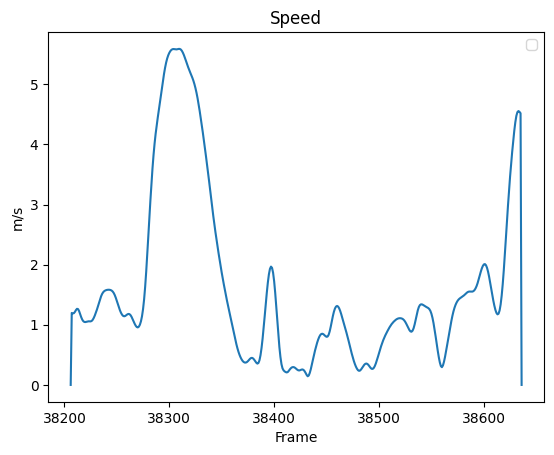

In [26]:
framePlotDF = smoothDF[(smoothDF['frame_id'] >= start_frame) & (smoothDF['frame_id'] <= end_frame)]
plt.plot(framePlotDF['frame_id'], framePlotDF['speed'])

plt.title('Speed')
plt.xlabel('Frame')  # Replace 'Index' with the actual x-axis label
plt.ylabel('m/s')  # Replace 'Value' with the actual y-axis label
plt.legend()
# plt.xlim(38222, 38335)
plt.show()

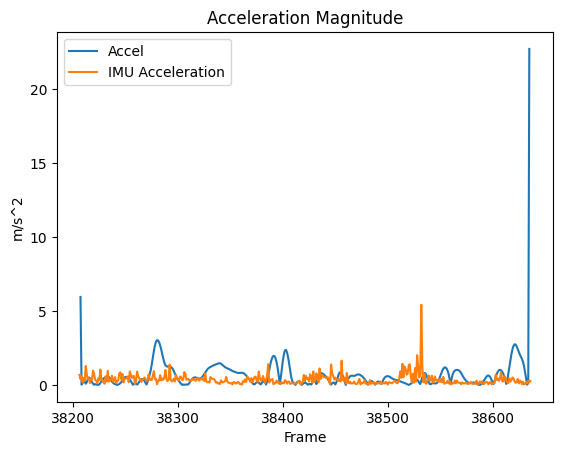

In [27]:
plt.plot(framePlotDF['frame_id'], framePlotDF['acceleration'].apply(lambda x: abs(x)), label='Accel')
plt.plot(framePlotDF['frame_id'], framePlotDF['IMU Acceleration Magnitude 2D'], label='IMU Acceleration')


plt.title('Acceleration Magnitude')
plt.xlabel('Frame')  # Replace 'Index' with the actual x-axis label
plt.ylabel('m/s^2')  # Replace 'Value' with the actual y-axis label
plt.legend()
# plt.xlim(38222, 38335)
plt.show()

<h2>Noise Experiments</h2>

In [28]:
def noiseHelper(p1, p, p2, lateralNoise, longitudinalNoise):
    longVec = np.array([p2['x'] - p1['x'], p2['y'] - p1['y']])
    latVec = np.array([-longVec[1], longVec[0]])
    new_p = np.array([p['x'], p['y']])

    alpha = 0
    beta = 0
    
    if(lateralNoise[0] == 'normal'):
        alpha = np.random.normal(lateralNoise[1], lateralNoise[2])
    
    if(longitudinalNoise[0] == 'normal'):
        beta = np.random.normal(longitudinalNoise[1], longitudinalNoise[2])

    new_p = new_p + alpha*latVec + beta*longVec

    return (new_p[0], new_p[1])

In [29]:
def applyNoise(trajectory, lateralNoiseType, longitudinalNoiseType):
    trajectoryCopy = trajectory.copy()
    for i, row in trajectoryCopy.iterrows():
        if i == 0 or i == len(trajectoryCopy) - 1:
            continue
        trajectoryCopy.loc[i, 'x'], trajectoryCopy.loc[i, 'y'] = noiseHelper(trajectory.loc[i-1], trajectory.loc[i], trajectory.loc[i+1], lateralNoiseType, longitudinalNoiseType)
    
    return trajectoryCopy

In [90]:
isolatedTraj['object_id'] = playerID
isolatedTraj.columns = ['x', 'y', 'speed', 'time', 'frame_id', 'object_id']
noisyTraj = applyNoise(isolatedTraj.copy(), ['normal', 0, 0.5], ['normal', 0, 1])
noisyTraj['object_id'] = playerID
noisyTraj


,x,y,speed,time,frame_id,object_id
0,11.980000,2.060000,0,1970-01-01 01:13:20.600,38206,59893
1,11.794627,1.878133,0,1970-01-01 01:13:20.700,38207,59893
2,11.896660,1.962172,0,1970-01-01 01:13:20.800,38208,59893
3,11.754564,1.817787,0,1970-01-01 01:13:20.900,38209,59893
4,11.772843,1.719619,0,1970-01-01 01:13:21.000,38210,59893
...,...,...,...,...,...,...
426,36.678011,28.543002,0,1970-01-01 01:14:03.200,38632,59893
427,37.772952,27.589059,0,1970-01-01 01:14:03.300,38633,59893
428,37.874945,28.718553,0,1970-01-01 01:14:03.400,38634,59893
429,38.501500,27.682156,0,1970-01-01 01:14:03.500,38635,59893


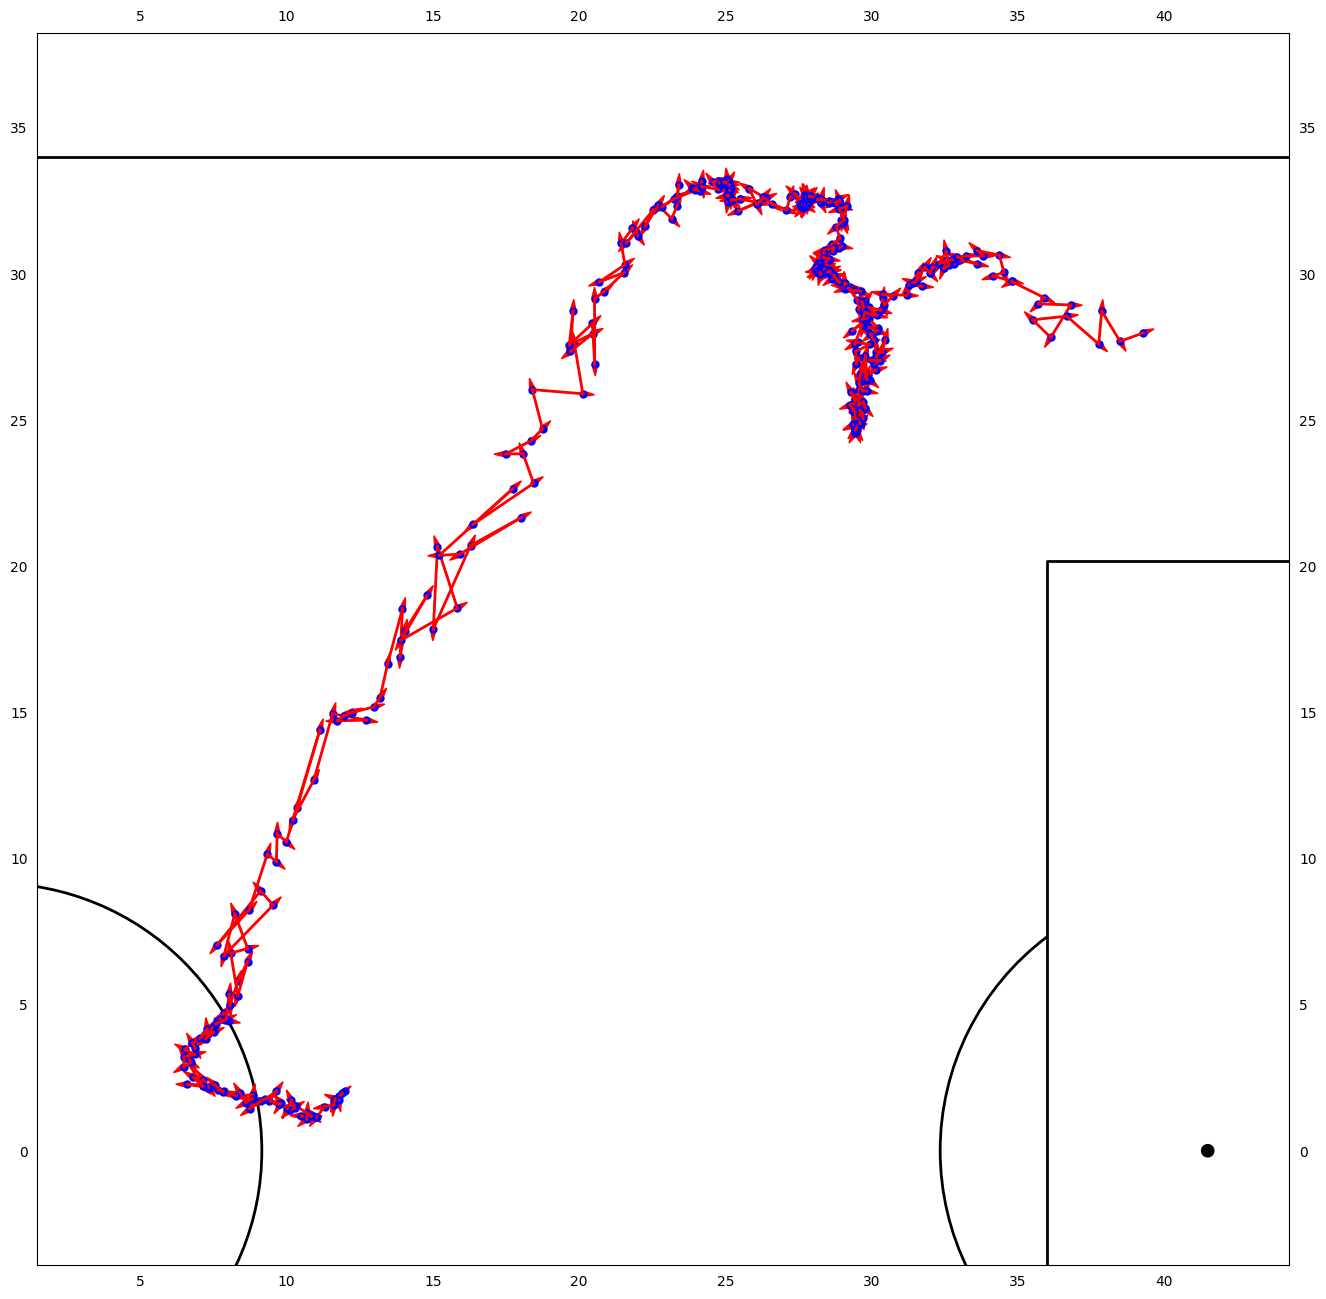

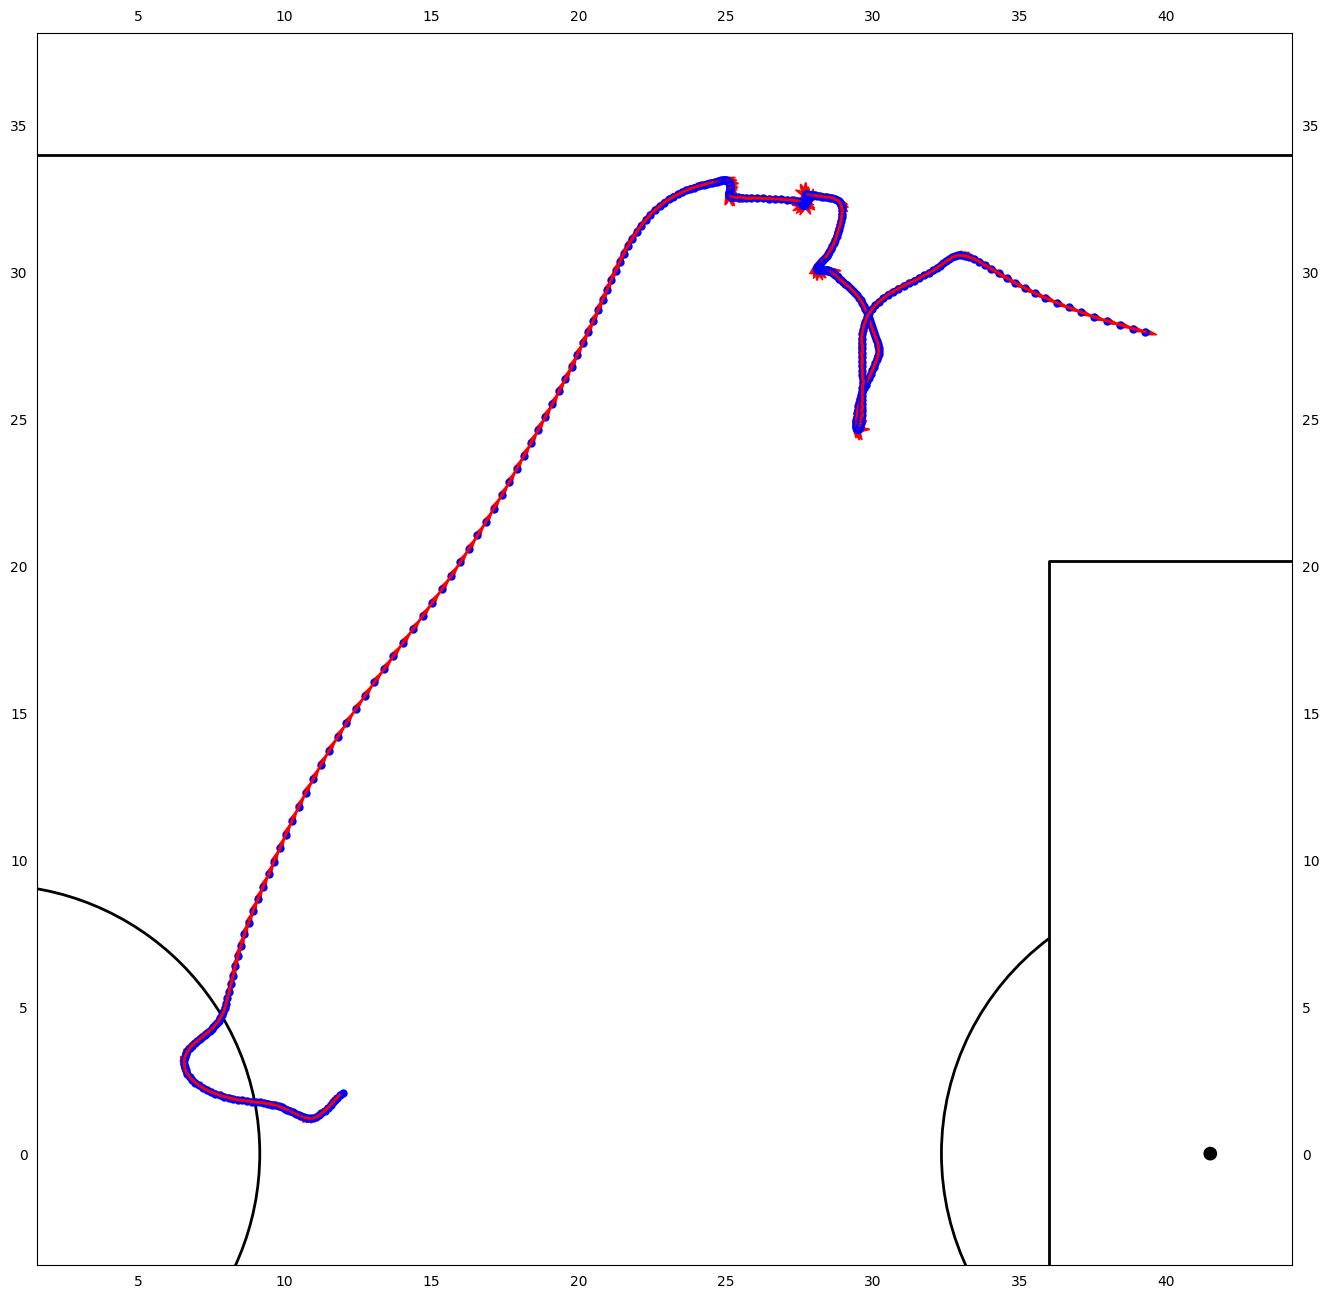

DTW distance before smoothing 8.370211729686986


In [91]:
plotMovement(playerID, noisyTraj, start_frame, end_frame)
plotMovement(playerID, isolatedTraj, start_frame, end_frame)

print(f"DTW distance before smoothing {getDTWDistance(isolatedTraj, noisyTraj)}")


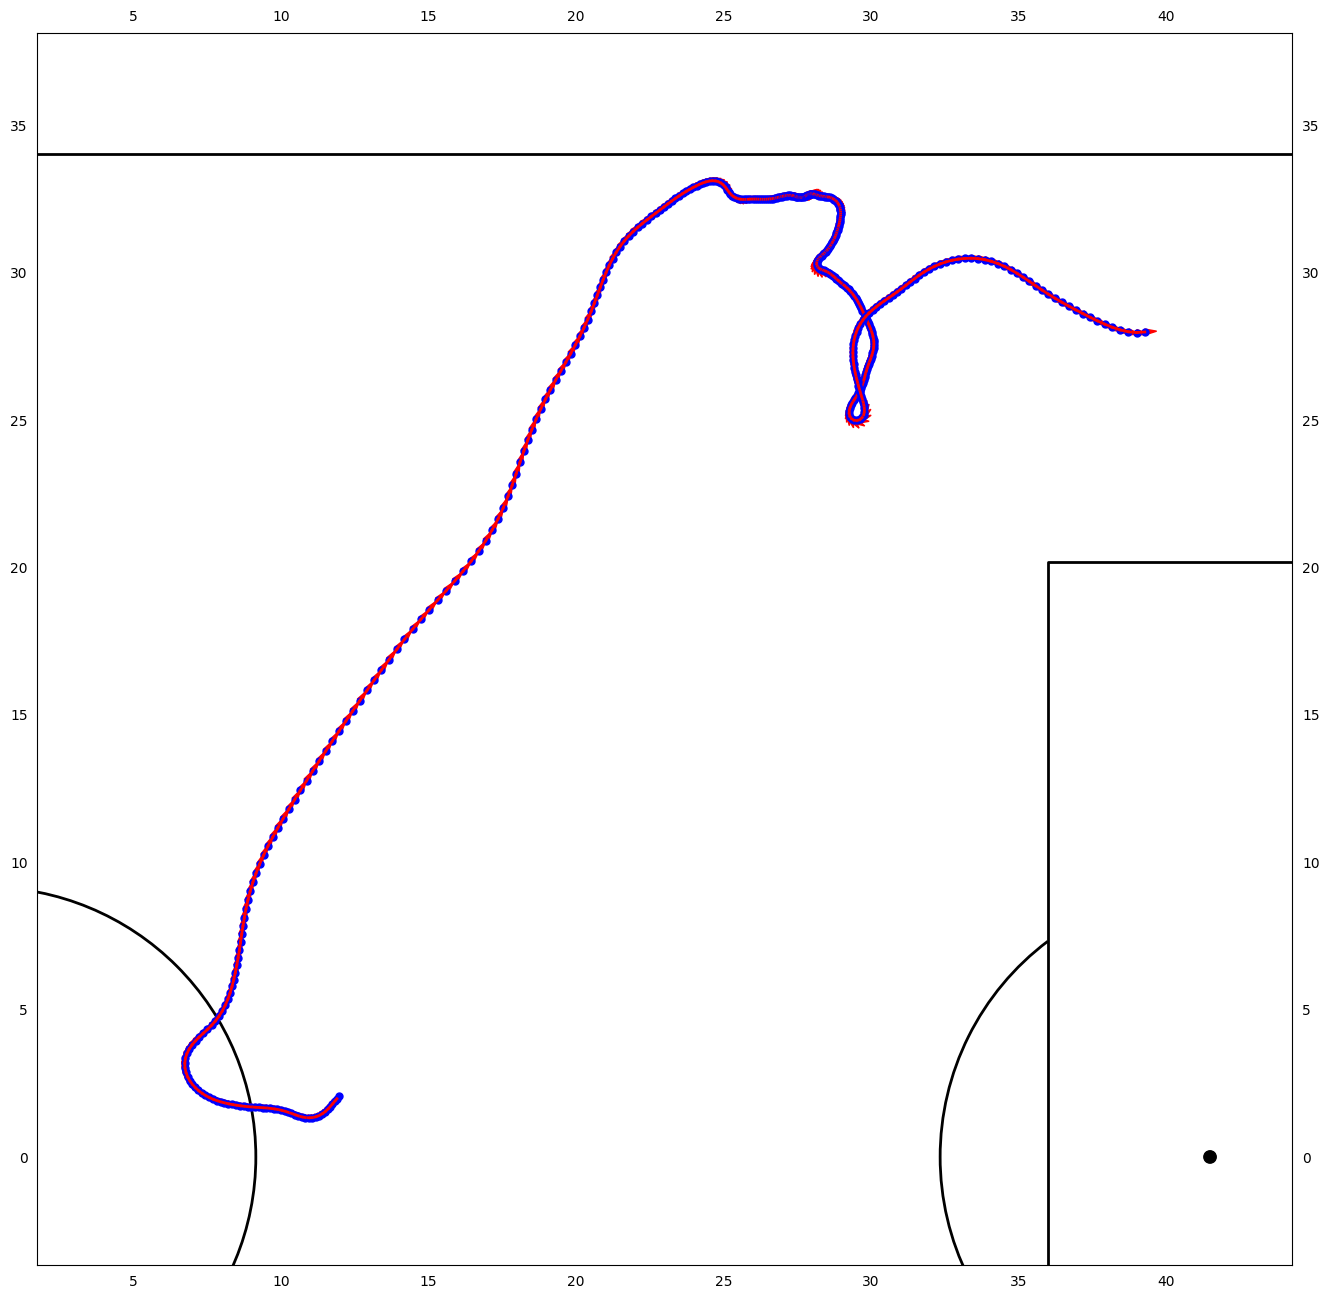

Trajectory similarity after smoothing 3.3118202976923623


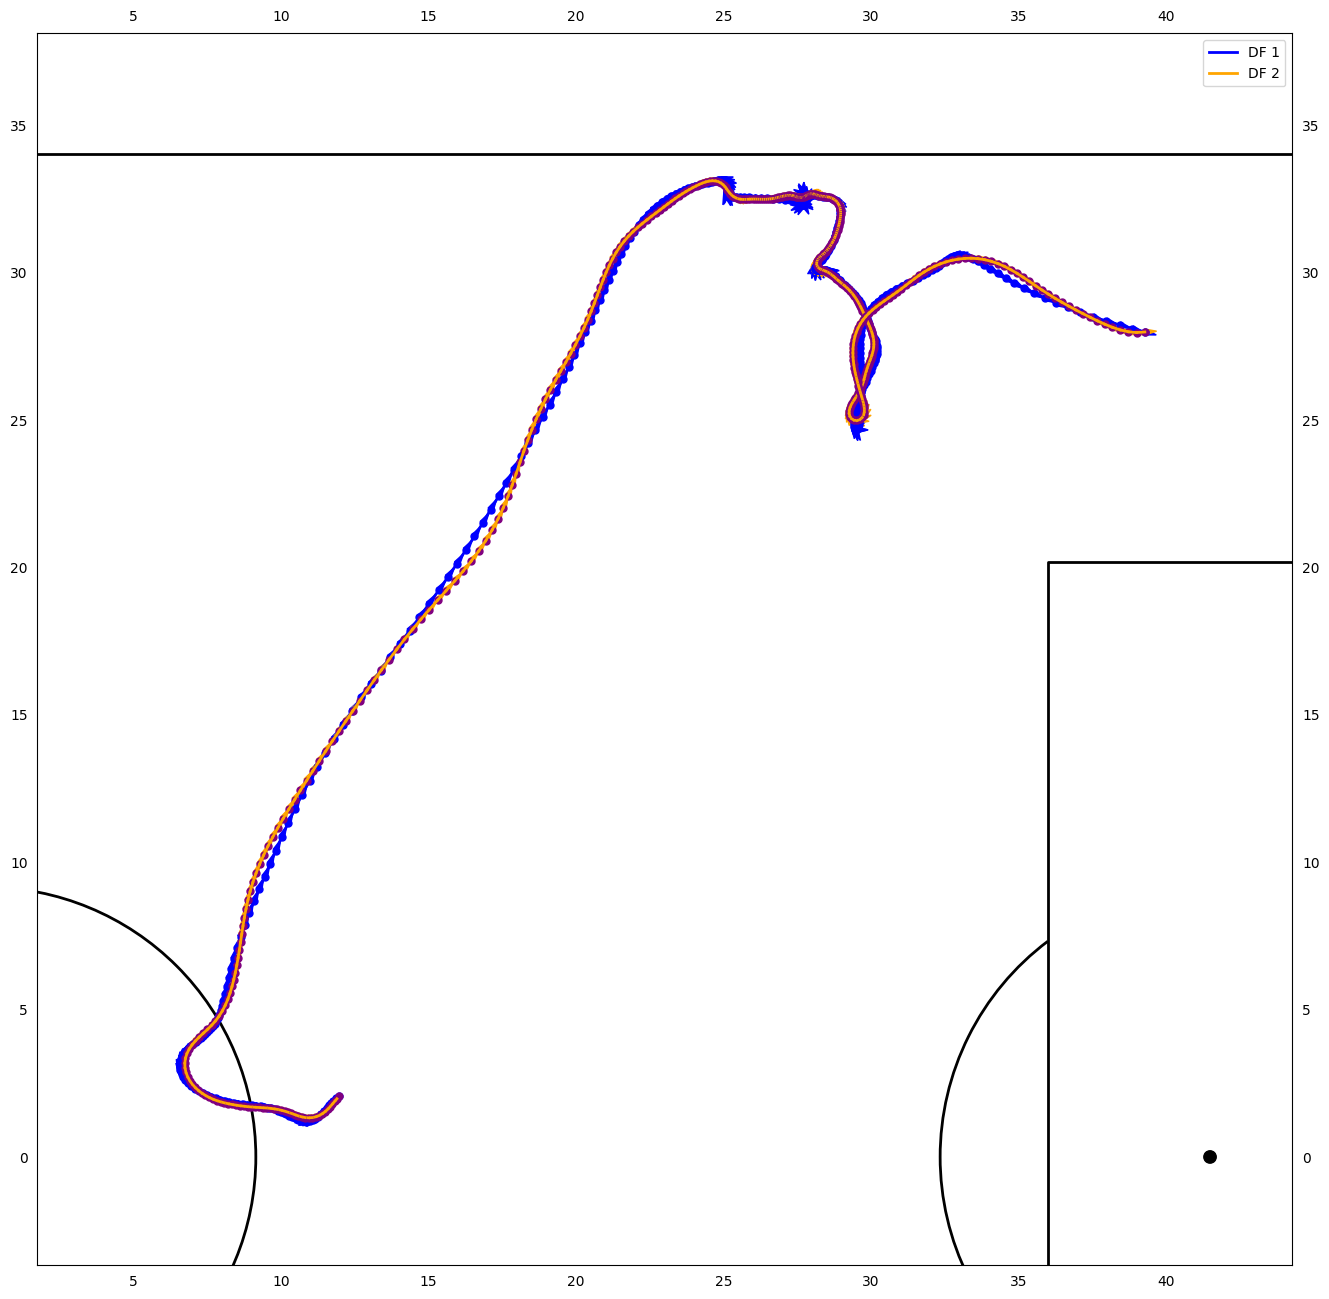

In [92]:
smoothNoisy = pd.DataFrame(performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 1000))
smoothNoisy.columns = ['x', 'y', 'speed', 'time', 'frame_id']
smoothNoisy['object_id'] = playerID
smoothNoisy['frame_id'] = noisyTraj['frame_id']
plotMovement(playerID, smoothNoisy, start_frame, end_frame)
print(f"Trajectory similarity after smoothing {getDTWDistance(isolatedTraj, smoothNoisy)}")
plotMovements(playerID, [isolatedTraj, smoothNoisy], start_frame, end_frame)


In [93]:
def reformatDF(df):
    df.columns = ['x', 'y', 'speed', 'time', 'frame_id']
    df['frame_id'] = isolatedTraj['frame_id']
    df['object_id'] = playerID
    return df

smoothNoisyDFs = [
    performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 1),
    performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 2),
    performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 4),
    performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 10),
    performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 50),
    performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 100),
    performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 200),
    performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 400),
    # performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 600),
    # performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 800),
    performSmoothing(noisyTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 2000),
]

smoothDFs = [
    performSmoothing(isolatedTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 1),
    performSmoothing(isolatedTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 2),
    performSmoothing(isolatedTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 4),
    performSmoothing(isolatedTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 10),
    performSmoothing(isolatedTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 50),
    performSmoothing(isolatedTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 100),
    performSmoothing(isolatedTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 200),
    performSmoothing(isolatedTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 400),
    performSmoothing(isolatedTraj[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 2000),
]
its = [1, 2, 4, 10, 50, 100, 200, 400,
        # 200, 400, 600, 800, 1000
    ]

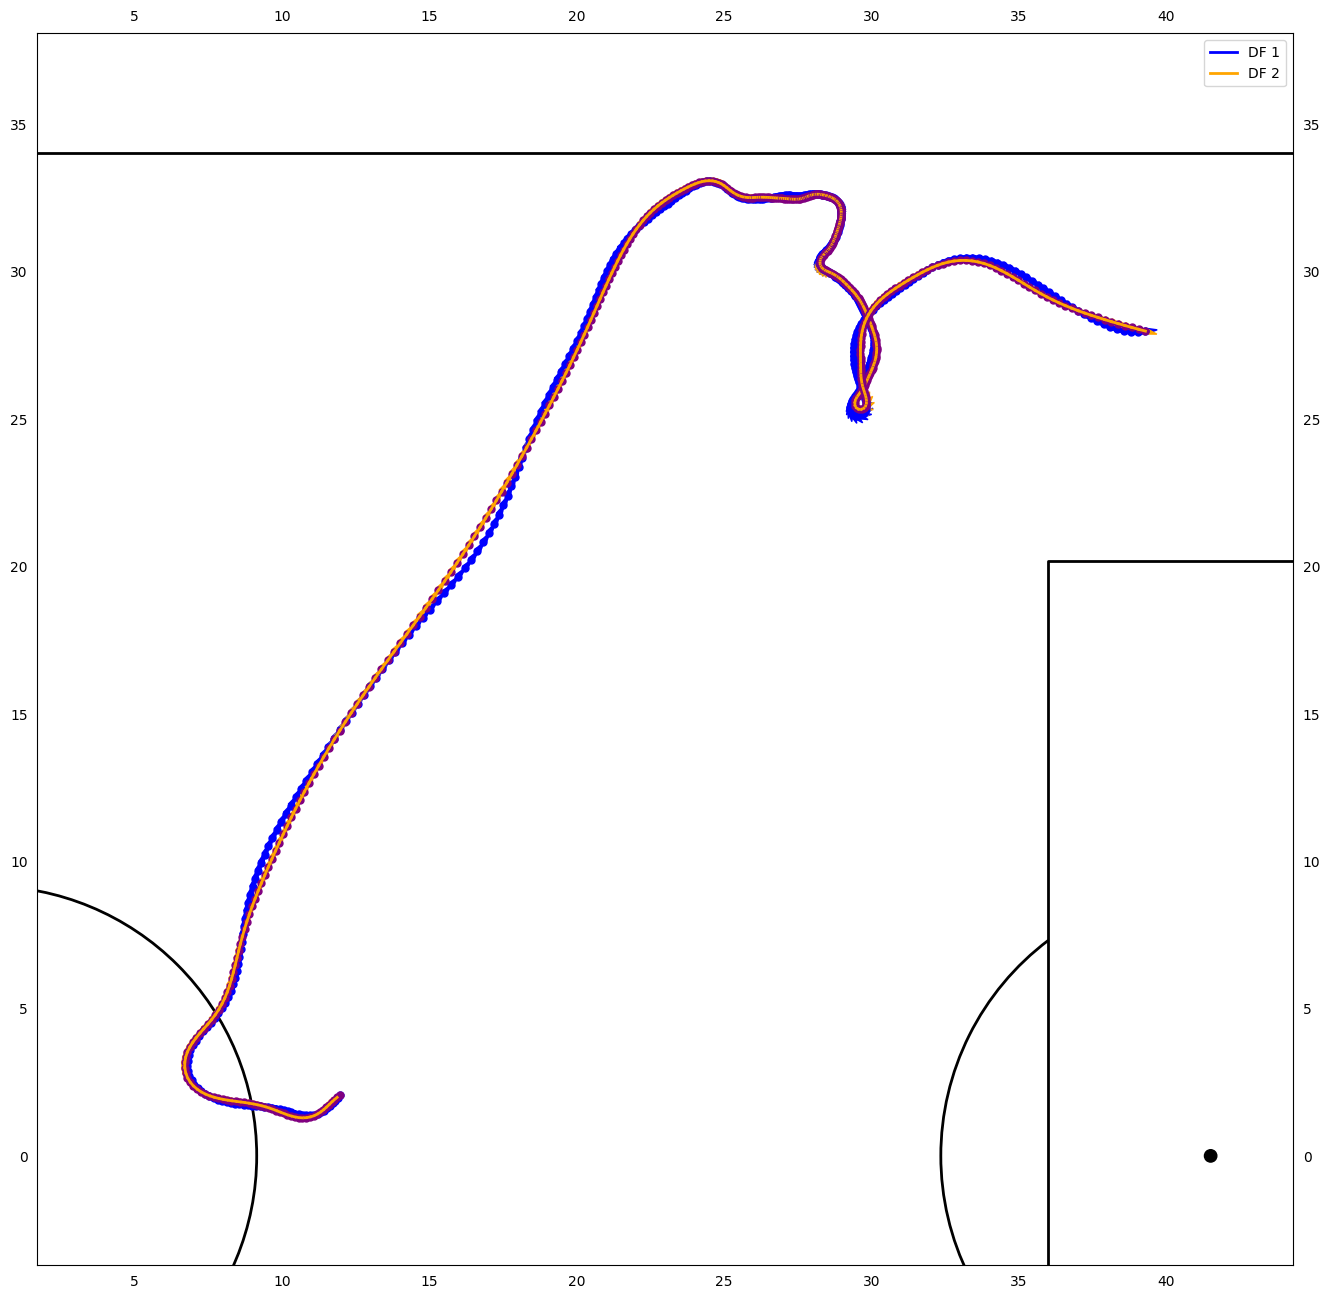

In [94]:
plotMovements(playerID, [reformatDF(pd.DataFrame(smoothNoisyDFs[-1])), reformatDF(pd.DataFrame(smoothDFs[-1]))], start_frame, end_frame)


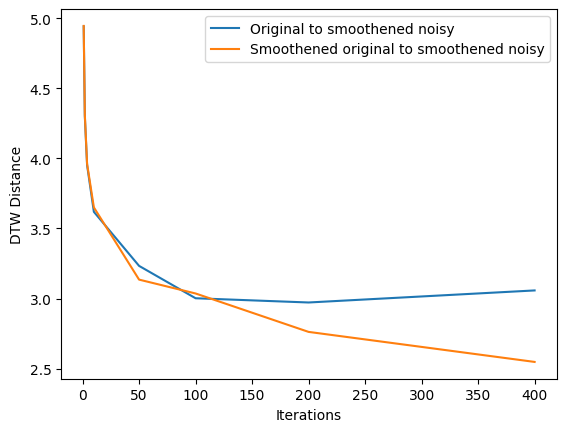

In [95]:
plt.plot(its[:8], list(map(lambda x: getDTWDistance(isolatedTraj, reformatDF(pd.DataFrame(x))), smoothNoisyDFs))[:8], label='Original to smoothened noisy')
plt.plot(its[:8], list(map(lambda x: getDTWDistance(reformatDF(pd.DataFrame(x[1])), reformatDF(pd.DataFrame(smoothNoisyDFs[x[0]]))), enumerate(smoothDFs)))[:8], label='Smoothened original to smoothened noisy')
# plt.title('Similarity of smoothened noisy trajectory to original trajectory for different amounts of iterations')
plt.xlabel('Iterations')  # Replace 'Index' with the actual x-axis label
plt.ylabel('DTW Distance')  # Replace 'Value' with the actual y-axis label  
plt.legend()
plt.show()

In [100]:
import os
from multiprocessing import Pool, current_process

allTrajs = targetTrajs.items()
dtwDistancesToOriginal = np.zeros(8, float)
dtwDistancesToSmoothened = np.zeros(8, float)
numTrajs = 0
its = [1, 2, 4, 10, 50, 100, 200, 400]

def perTrajectory(player, playerTrajs, trajectory):
    dtwOriginal = np.zeros(8, float)
    dtwSmooth = np.zeros(8, float)
    print(numTrajs/len(playerTrajs))
    numTrajs += 1
    trajectory = pd.DataFrame(trajectory)
    trajectory['object_id'] = player
    trajectory.columns = ['x', 'y', 'speed', 'time', 'frame_id', 'object_id']
    noisyTrajectory = applyNoise(trajectory.copy(), ['normal', 0, 0.5], ['normal', 0, 1])
    noisyTrajectory['object_id'] = player

    smoothTrajs = [
        performSmoothing(trajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 1),
        performSmoothing(trajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 2),
        performSmoothing(trajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 4),
        performSmoothing(trajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 10),
        performSmoothing(trajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 50),
        performSmoothing(trajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 100),
        performSmoothing(trajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 200),
        performSmoothing(trajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 400),
    ]
    noisyTrajs = [
        performSmoothing(noisyTrajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 1),
        performSmoothing(noisyTrajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 2),
        performSmoothing(noisyTrajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 4),
        performSmoothing(noisyTrajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 10),
        performSmoothing(noisyTrajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 50),
        performSmoothing(noisyTrajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 100),
        performSmoothing(noisyTrajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 200),
        performSmoothing(noisyTrajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 400),
    ]
    for i, s in enumerate(smoothTrajs):
        dtwOriginal[i] = getDTWDistance(isolatedTraj, reformatDF(pd.DataFrame(noisyTrajs[i])))
        dtwSmooth[i] = getDTWDistance(reformatDF(pd.DataFrame(s)), reformatDF(pd.DataFrame(noisyTrajs[i])))

    return dtwOriginal, dtwSmooth


if __name__ == '__main__':
    with Pool(5) as p:
        for(player, playerTrajs) in allTrajs:
            numTrajs += 1
            for origdist, smoothdist in list(p.map(perTrajectory, [1, 2, 3])):
                dtwDistancesToOriginal += origdist
                dtwDistancesToSmoothened += smoothdist
            
# for player, playerTrajs in allTrajs:
#     for trajectory in playerTrajs:
#         print(numTrajs/len(playerTrajs))
#         numTrajs += 1
#         trajectory = pd.DataFrame(trajectory)
#         trajectory['object_id'] = player
#         trajectory.columns = ['x', 'y', 'speed', 'time', 'frame_id', 'object_id']
#         noisyTrajectory = applyNoise(trajectory.copy(), ['normal', 0, 0.5], ['normal', 0, 1])
#         noisyTrajectory['object_id'] = player

#         smoothTrajs = [
#             performSmoothing(trajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 1),
#             performSmoothing(trajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 2),
#             performSmoothing(trajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 4),
#             performSmoothing(trajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 10),
#             performSmoothing(trajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 50),
#             performSmoothing(trajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 100),
#             performSmoothing(trajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 200),
#             performSmoothing(trajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 400),
#         ]
#         noisyTrajs = [
#             performSmoothing(noisyTrajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 1),
#             performSmoothing(noisyTrajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 2),
#             performSmoothing(noisyTrajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 4),
#             performSmoothing(noisyTrajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 10),
#             performSmoothing(noisyTrajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 50),
#             performSmoothing(noisyTrajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 100),
#             performSmoothing(noisyTrajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 200),
#             performSmoothing(noisyTrajectory[['x', 'y', 'speed', 'time', 'frame_id']].values.tolist(), 400),
#         ]
#         for i, s in enumerate(smoothTrajs):
#             dtwDistancesToOriginal[i] += getDTWDistance(trajectory, reformatDF(pd.DataFrame(noisyTrajs[i])))
#             dtwDistancesToSmoothened[i] += getDTWDistance(reformatDF(pd.DataFrame(s)), reformatDF(pd.DataFrame(noisyTrajs[i])))
#     break

# print(dtwDistancesToOriginal, numTrajs)
plt.plot(its, dtwDistancesToOriginal, label='Original to smoothened noisy')
plt.plot(its, dtwDistancesToSmoothened, label='Smoothened original to smoothened noisy')
plt.xlabel('Iterations') 
plt.ylabel('DTW Distance') 
plt.legend()
plt.show()

Process SpawnPoolWorker-1:
Process SpawnPoolWorker-2:
Traceback (most recent call last):
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'perTrajectory' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "/Applications/Xc

KeyboardInterrupt: 

Conclusion from DTW plot: 
- We can see that the distance to the original trajectory is minimal at around 10 iterations, which is quite unexpected, since visually it seems that around 100 iterations is better at completely removing the noise
- As expected, when smoothing both the noisy and original trajectory they converge slowly to a similar trajectory

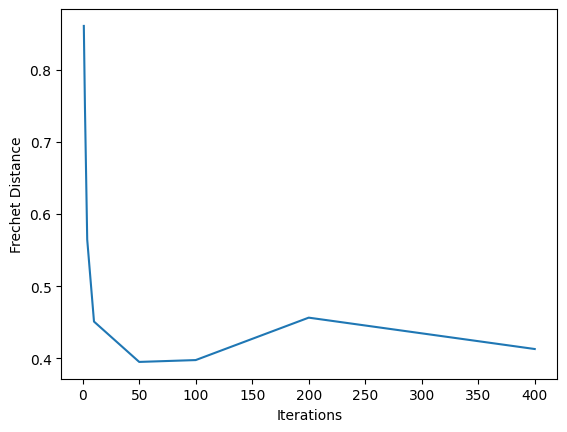

In [ ]:
plt.plot(its[:8], list(map(lambda x: getFrechetDistance(isolatedTraj, reformatDF(pd.DataFrame(x))), smoothNoisyDFs[:8])))
# plt.title('Similarity of smoothened noisy trajectory to original trajectory for different amounts of iterations')
plt.xlabel('Iterations')  # Replace 'Index' with the actual x-axis label
plt.ylabel('Frechet Distance')  # Replace 'Value' with the actual y-axis label  
plt.show()

Interesting, inspect frechet distance computation. What happens between 100 and 200?

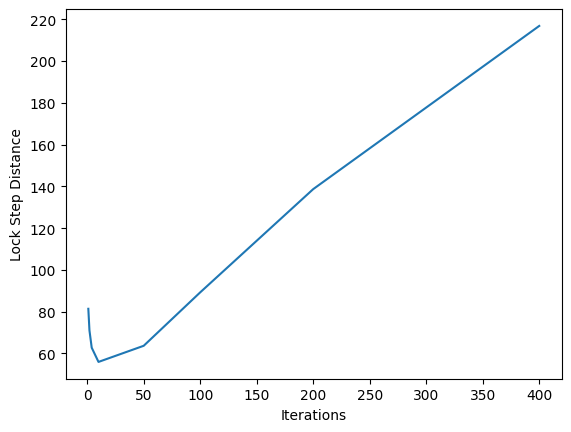

In [ ]:
plt.plot(its[:8], list(map(lambda x: getLockStepDistance(isolatedTraj, reformatDF(pd.DataFrame(x))), smoothNoisyDFs[:8])))
# plt.title('Similarity of smoothened noisy trajectory to original trajectory for different amounts of iterations')
plt.xlabel('Iterations')  # Replace 'Index' with the actual x-axis label
plt.ylabel('Lock Step Distance')  # Replace 'Value' with the actual y-axis label  
plt.show()